In [1]:
import os
os.chdir("..")
from IPython.display import display
import pandas
import matplotlib.pyplot

In [2]:
import pathlib
import pandas
import numpy
import functools
import collections
import hashlib
import charmonium.time_block
from typing import Mapping, Callable
from util import flatten1
from prov_collectors import PROV_COLLECTORS
from workloads import WORKLOADS


rel_qois = ["cputime", "walltime", "memory"]
abs_qois = ["storage", "n_ops", "n_unique_files"]
output = pathlib.Path("output")
output.mkdir(exist_ok=True)

In [5]:
from experiment import get_results
from workloads import WORKLOAD_GROUPS
from prov_collectors import PROV_COLLECTOR_GROUPS
from util import flatten1

collectors = list(flatten1([
    PROV_COLLECTOR_GROUPS[collector_name]
    for collector_name in ["working"]
]))
workloads = list(flatten1([
    WORKLOAD_GROUPS[workload_name]
    for workload_name in ["working"]
]))
iterations = 2
ignore_failures = True
rerun = False
df = get_results(
    collectors,
    workloads,
    iterations=iterations,
    seed=0,
    ignore_failures=ignore_failures,
    rerun=rerun,
    parallelism=1,
)

# Find noprov-workloads with abnormally high deviation

In [6]:
import functools
import collections
import operator

In [7]:
agged = (
    df
    .groupby(["collector", "workload"], observed=True, as_index=True)
    .agg(**{
        **{
            f"{qoi}_std": pandas.NamedAgg(qoi, "std")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_mean": pandas.NamedAgg(qoi, "mean")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_low": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 5))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_high": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 95))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_sorted": pandas.NamedAgg(qoi, lambda data: list(sorted(data)))
            for qoi in abs_qois + rel_qois
        },
        "op_type_counts_sum": pandas.NamedAgg("op_type_counts", lambda op_type_freqs: functools.reduce(operator.add, op_type_freqs, collections.Counter())),
        "count": pandas.NamedAgg("walltime", lambda walltimes: len(walltimes)),
    })
    .assign(**{
        **{
            f"{qoi}_rel": lambda df, qoi=qoi: df[f"{qoi}_std"] / df[f"{qoi}_mean"]
            for qoi in abs_qois + rel_qois
        },
        "rel_slowdown": lambda df: df["walltime_mean"] / df.loc["noprov"]["walltime_mean"],
    })
    .assign(**{
        "log_rel_slowdown": lambda df: numpy.log(df["rel_slowdown"]),
    })
)

# Identify failures

In [12]:
df = df[df["workload"] != "spack spack-repo.apacheHttpd"]

In [13]:
df[df["walltime"] < 0.001]

,collector,collector_method,collector_submethod,workload,workload_kind,cputime,walltime,memory,storage,n_ops,n_unique_files,op_type_counts


# Pathological cases for each collector

In [14]:
agged.loc["noprov"]["rel_slowdown"].nlargest()

workload
a-data-sci       1.0
apache           1.0
archive          1.0
archive bzip2    1.0
archive gzip     1.0
Name: rel_slowdown, dtype: float64

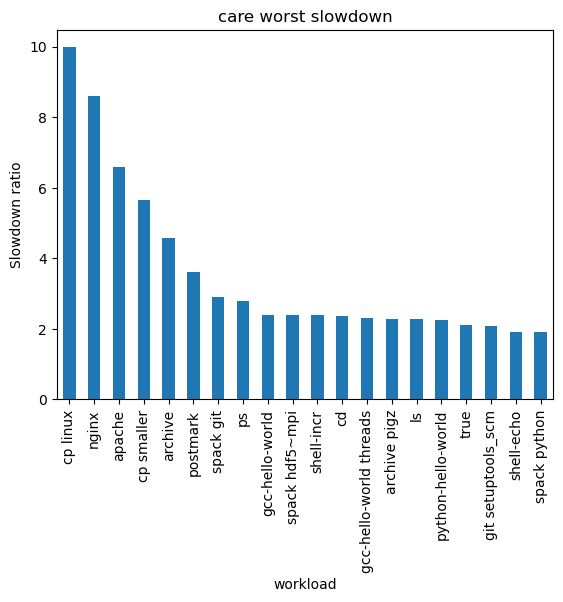

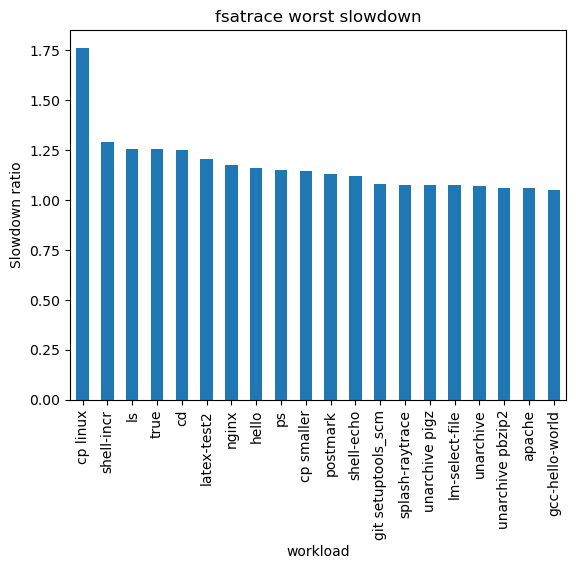

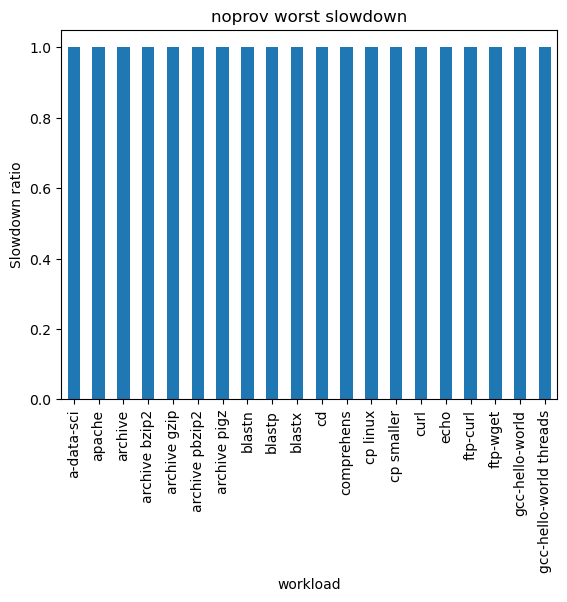

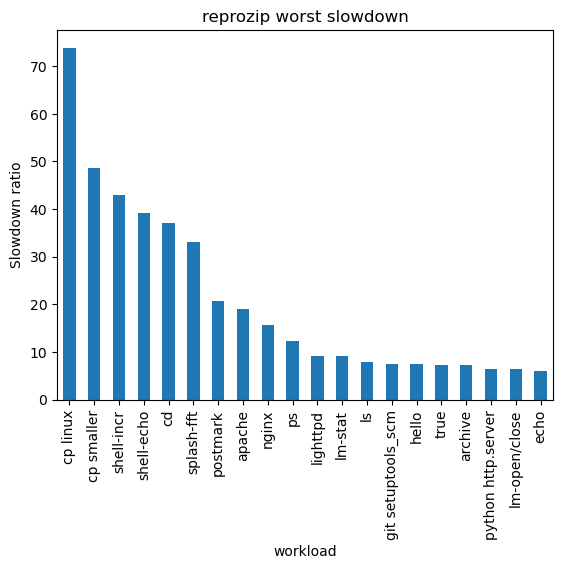

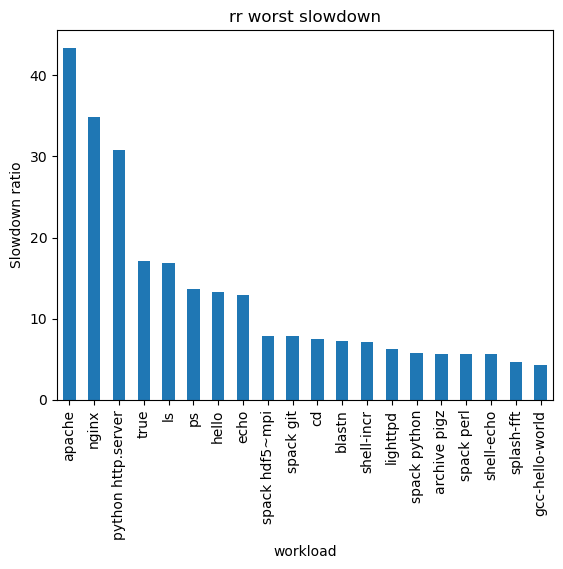

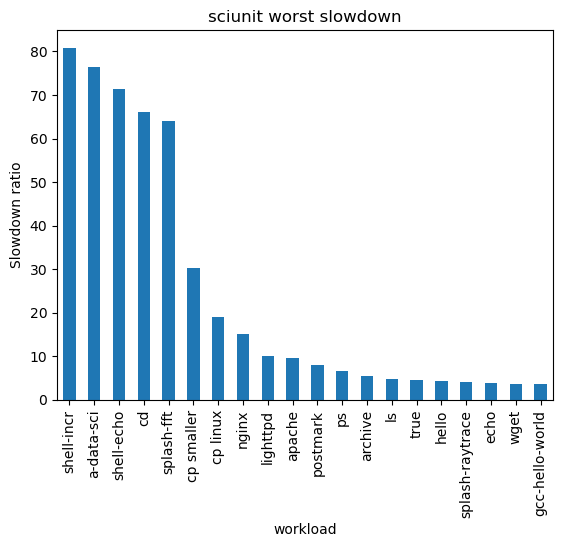

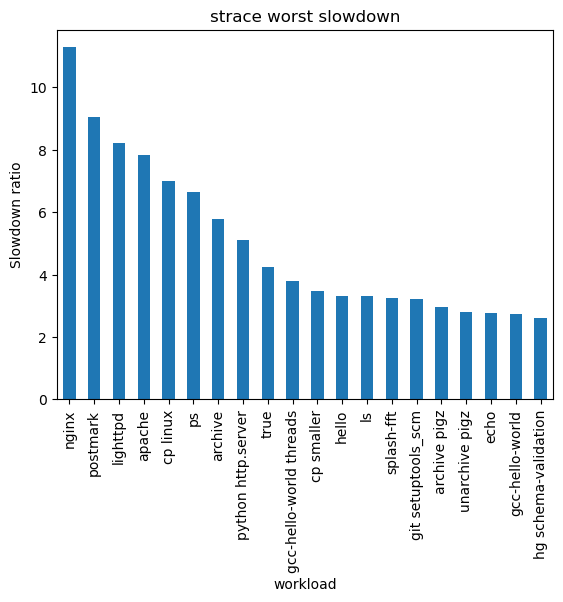

In [20]:
for collector in agged.index.levels[0]:
    fig = matplotlib.figure.Figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = agged.loc[collector]["rel_slowdown"].nlargest(20).plot.bar(ax=ax)
    ax.set_title(f"{collector} worst slowdown")
    ax.set_ylabel("Slowdown ratio")
    display(fig)

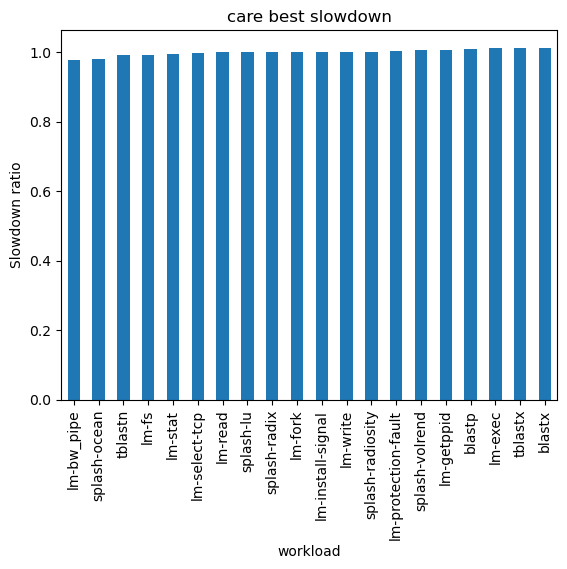

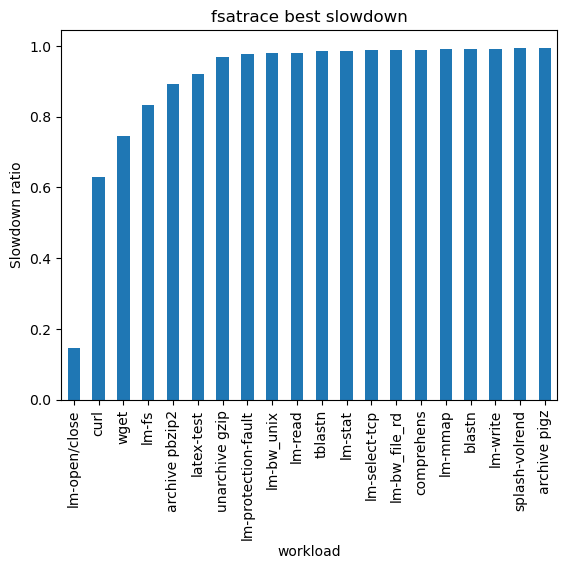

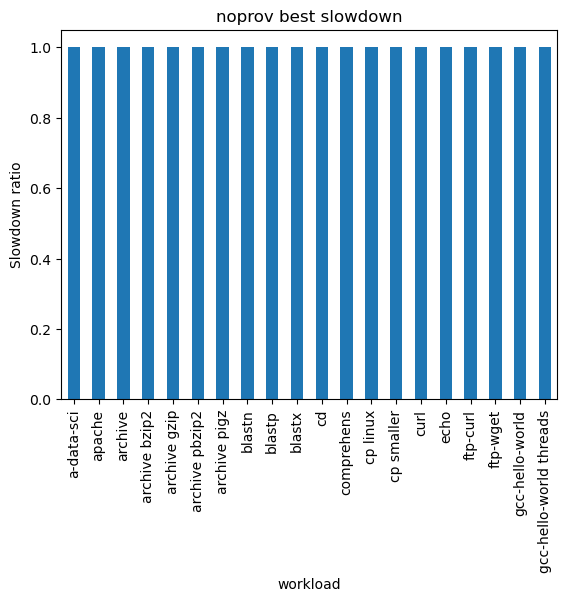

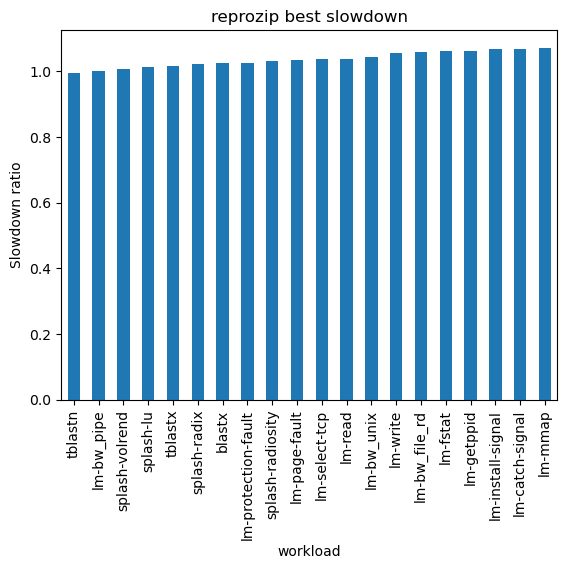

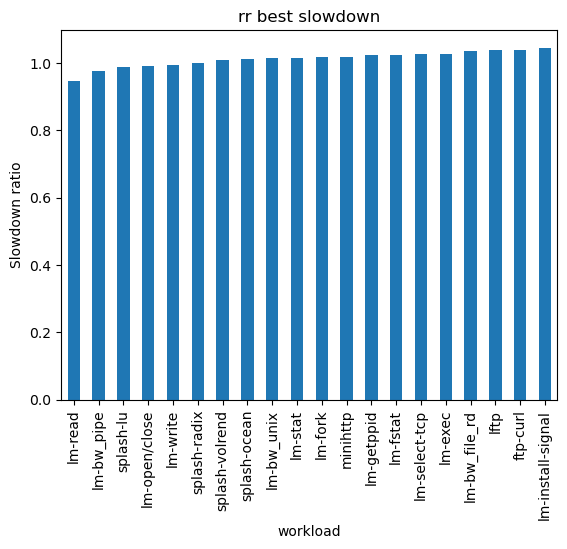

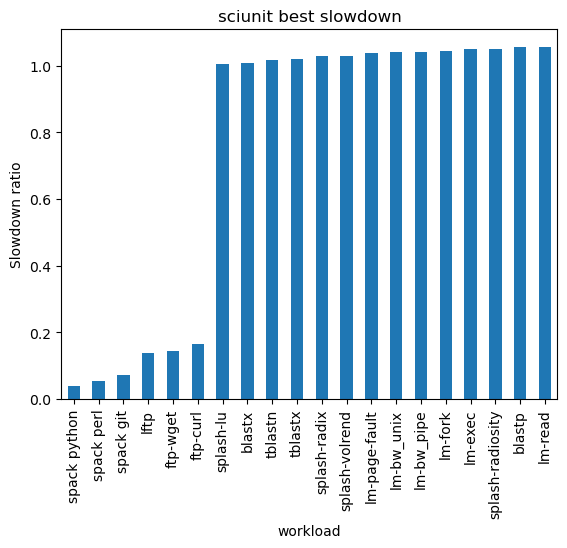

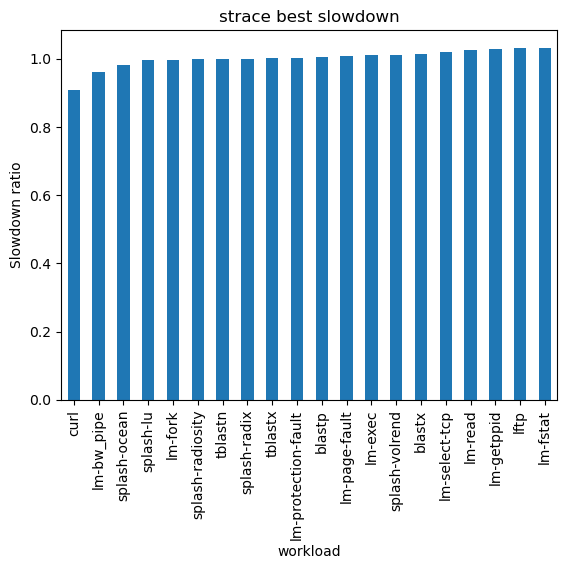

In [21]:
for collector in agged.index.levels[0]:
    fig = matplotlib.figure.Figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = agged.loc[collector]["rel_slowdown"].nsmallest(20).plot.bar(ax=ax)
    ax.set_title(f"{collector} best slowdown")
    ax.set_ylabel("Slowdown ratio")
    display(fig)

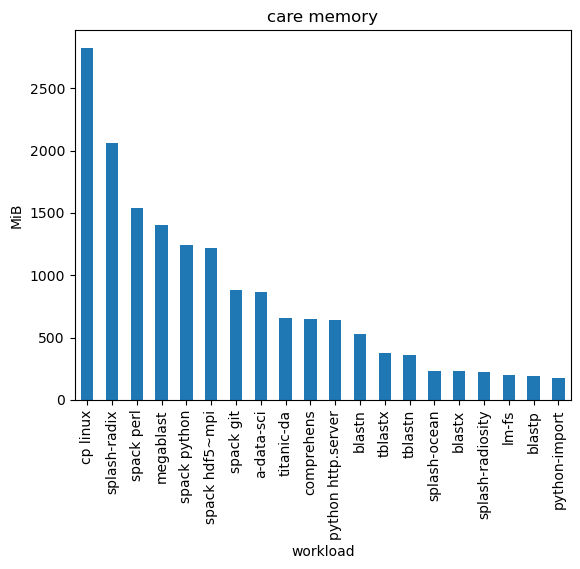

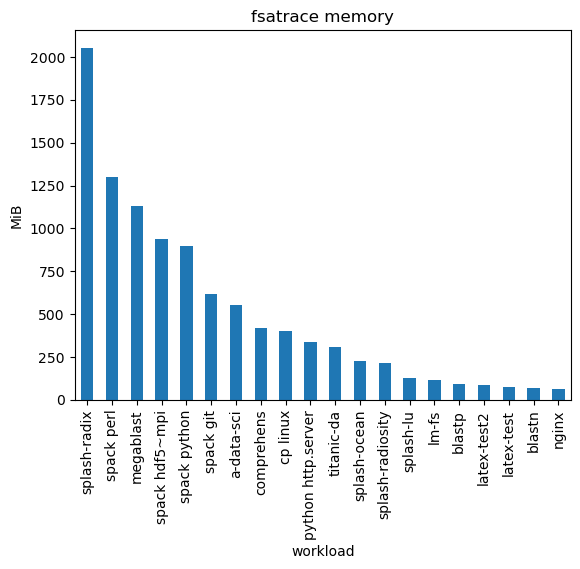

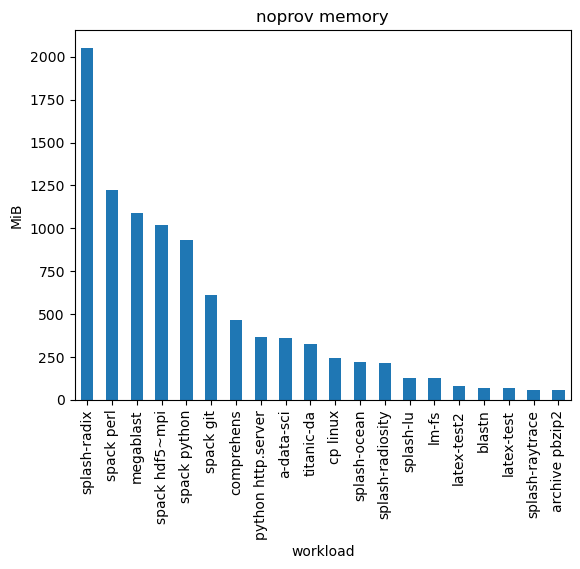

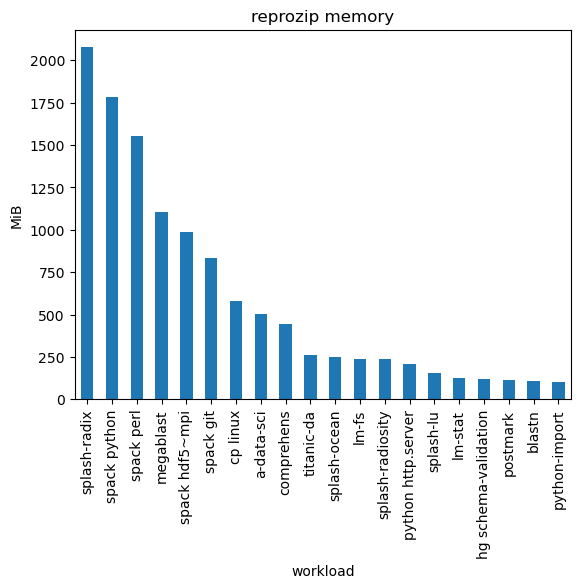

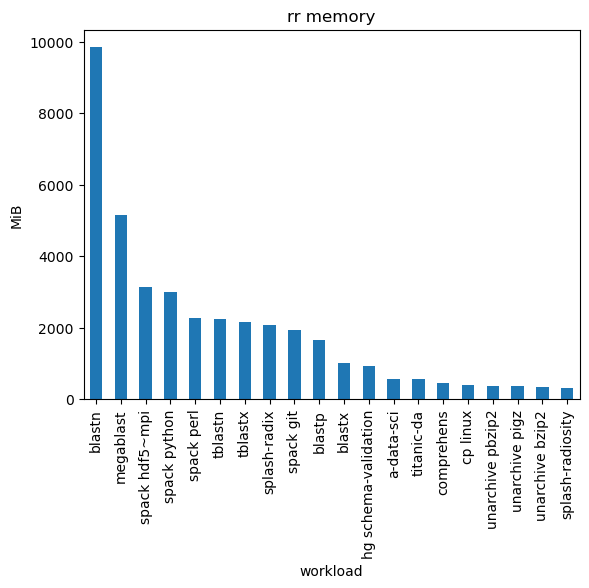

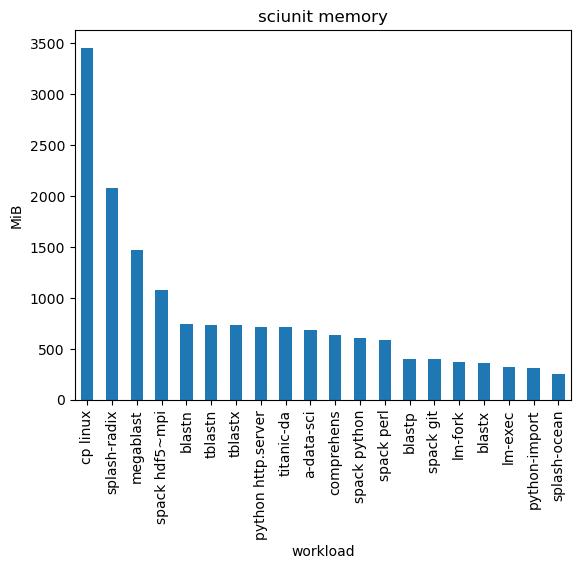

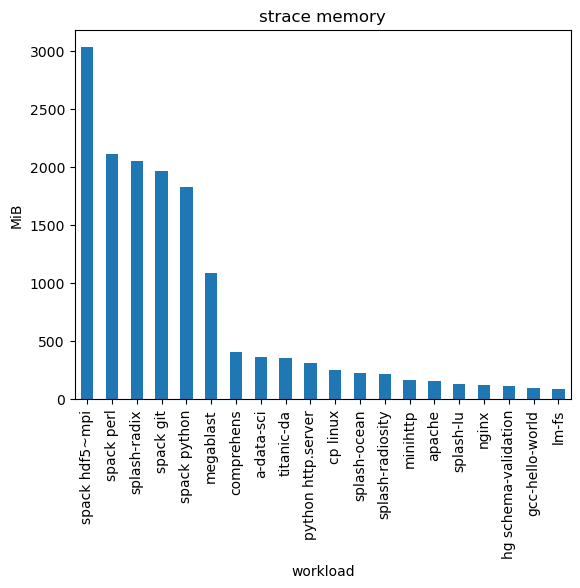

In [19]:
for collector in agged.index.levels[0]:
    fig = matplotlib.figure.Figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = (agged.loc[collector]["memory_mean"] / 2**20).nlargest(20).plot.bar(ax=ax)
    ax.set_title(f"{collector} memory")
    ax.set_ylabel("MiB")
    display(fig)